# LSTM Intent Classifier (No TorchText)
This notebook trains an LSTM model for intent classification without using torchtext.

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import time
import re
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tokenizer function
def simple_tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

start_time = time.time()

# Load dataset
df = pd.read_csv("final_combined_grouped_dataset.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.4, random_state=42)


In [13]:
# Build vocabulary
all_tokens = [token for text in X_train for token in simple_tokenizer(text)]
counter = Counter(all_tokens)
vocab = {"<pad>": 0, "<unk>": 1}
vocab.update({word: idx+2 for idx, (word, _) in enumerate(counter.items())})

def encode(text):
    return [vocab.get(token, vocab["<unk>"]) for token in simple_tokenizer(text)]


In [14]:
# Create Dataset and DataLoader
class IntentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(encode(text), dtype=torch.long) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_batch(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return padded, torch.tensor(labels)

train_dataset = IntentDataset(X_train.tolist(), y_train.tolist())
test_dataset = IntentDataset(X_test.tolist(), y_test.tolist())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)


In [15]:
# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.embedding(x)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(len(vocab), 64, 64, len(label_encoder.classes_)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


In [16]:
# Training loop
def train(model, loader):
    model.train()
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

for epoch in range(5):
    train(model, train_loader)
print("Training complete.")


Training complete.


                            precision    recall  f1-score   support

              check_return       1.00      0.77      0.87        62
             find_by_email       0.98      0.94      0.96        51
find_by_email+check_return       0.97      0.92      0.94        61
find_by_email+return_order       0.97      0.88      0.92        69
              return_order       0.82      1.00      0.90        47
               track_order       0.84      0.98      0.90        57
  track_order+check_return       0.74      1.00      0.85        57
  track_order+return_order       1.00      0.72      0.84        53

                  accuracy                           0.90       457
                 macro avg       0.91      0.90      0.90       457
              weighted avg       0.92      0.90      0.90       457



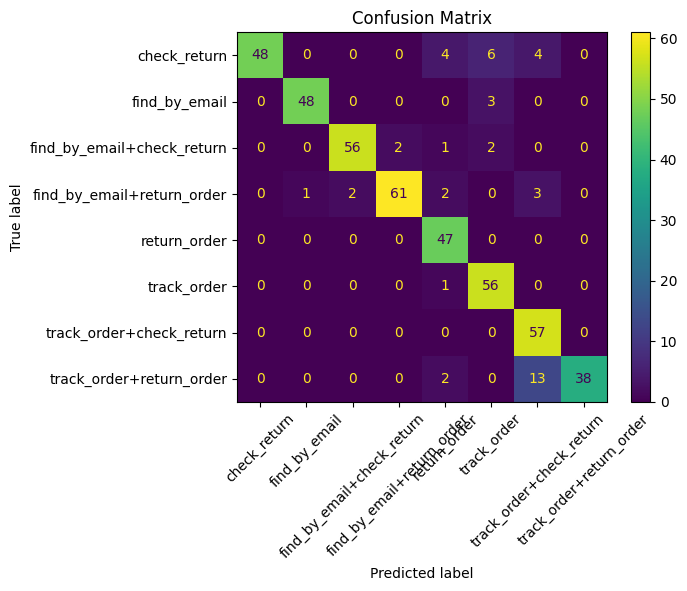

In [17]:
# Evaluation
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = model(texts)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
    return all_labels, all_preds

y_true, y_pred = evaluate(model, test_loader)
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [18]:
# Save model and components
os.makedirs("C:/Users/Anirudh/Desktop/nlp_project/checkpointss/lstm", exist_ok=True)
torch.save(model.state_dict(), "C:/Users/Anirudh/Desktop/nlp_project/checkpointss/lstm/best_model.pt")
joblib.dump(vocab, "C:/Users/Anirudh/Desktop/nlp_project/checkpointss/lstm/vocab.pkl")
joblib.dump(label_encoder, "C:/Users/Anirudh/Desktop/nlp_project/checkpointss/lstm/label_encoder.pkl")
print("Model, vocab, and label encoder saved.")


Model, vocab, and label encoder saved.


In [19]:
# Runtime log
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")


Training completed in 2.20 seconds


In [25]:
# Predict on custom input
def predict_intent(text):
    model.eval()
    encoded = torch.tensor(encode(text), dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(encoded)
        pred = torch.argmax(output, dim=1).item()
    return label_encoder.inverse_transform([pred])[0]

# Example
predict_intent(" pls,return order")


'track_order+check_return'